## Data set - LTI system
An LTI system is excited by an uniform signal $X \sim U[-1, 1]$

In [6]:
from volterra import *

# system parameters
sys_imp_resp_length = 20
sys_impulse_response = np.linspace(10, 0.5, sys_imp_resp_length)
sys = LTISystem(sys_impulse_response)

# noise signal parameters
z_sigma = 1

# generate learning batch
est_batch_size = 100
x_est = np.random.uniform(-1, 1, est_batch_size)
z_est = z_sigma * np.random.standard_normal(est_batch_size)
y_est = sys.evaluate_output(x_est) + z_est

# generate validation batch
val_batch_size = 1000
x_val = np.random.uniform(-1, 1, val_batch_size)
z_val = z_sigma * np.random.standard_normal(val_batch_size)
y_val = sys.evaluate_output(x_val) + z_val

## Aggregation algorithm

The algorithm aims to estimate Volterra model's parameters on an $\ell_1$-ball of radius $R$. 
Since, we know the $\ell_1$-norm of the true system's parameters we can choose optimal $R$.  

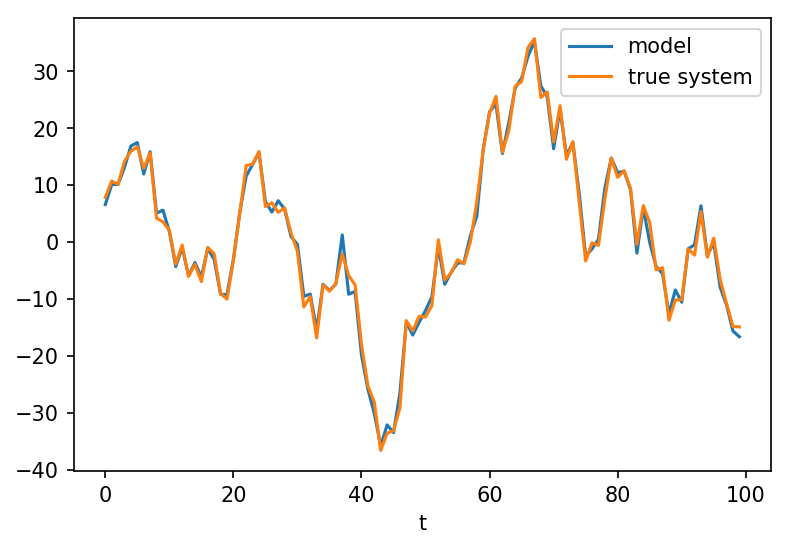

In [7]:
from aggregation import *
import matplotlib.pyplot as plt

# model parameters
model_order = 1
model_memory_len = sys_imp_resp_length
m = VolterraModel(model_order, model_memory_len)

params = aggregation_for_volterra(m.dictionary, x_est, y_est, R=np.linalg.norm(sys_impulse_response, 1))
m.set_parameters(params)

y_aggr = m.evaluate_output(x_val)

plt.rcParams['figure.dpi'] = 150
plt.plot(y_aggr[:100])
plt.plot(y_val[:100])
plt.xlabel('t')
plt.legend(['model', 'true system'])
plt.show()

## Entropic descent

To use this method we need following parameters:
- $\sigma_Z^2$ - variance of the noise signal
- $R$ - radius of the $\ell_1$-ball over which we estimate
- $M$ - the system's output magnitude

We also use a _scaling parameter_ that scales the stepsize - apparently the equation for its derivation doesn't work

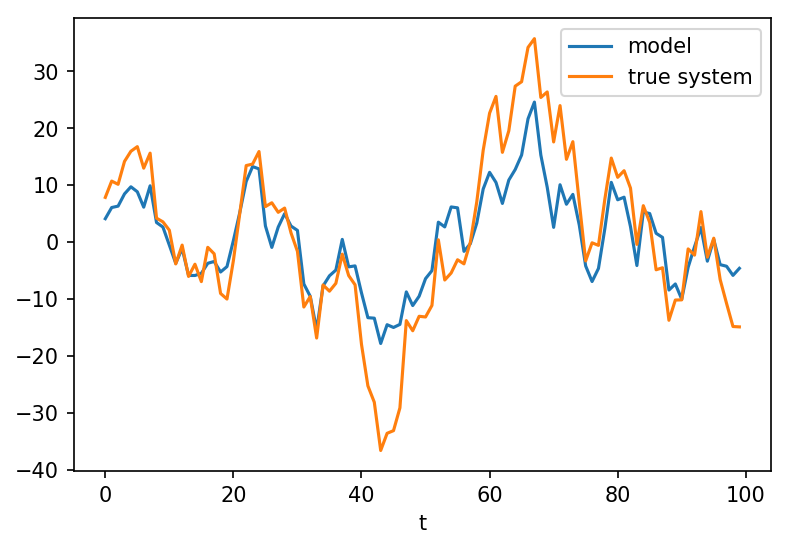

In [10]:
from entropic_descent import *

z_var = z_sigma ** 2
R = np.linalg.norm(sys_impulse_response, 1)
M = R

# model parameters
model_order = 1
model_memory_len = sys_imp_resp_length

m = VolterraModel(model_order, model_memory_len)
m_extended = VolterraModelForExpWeights(model_order, model_memory_len, scaling_factor=R)
D = m_extended.dictionary.size

G_sq = R ** 2 * ((R + M) ** 2 + z_var)

scaling_parameter = 100  # this is parameter for scaling the stepsize

stepsize = scaling_parameter * np.sqrt(2 * np.log(D) / (G_sq * (est_batch_size + 1)))
stepsize_function = lambda i: stepsize

alg = EntropicDescentAlgorithm(m_extended, stepsize_function)
extended_model_parameters = alg.run(x_est, y_est)
model_parameters = map_parameters(extended_model_parameters, R)
m.set_parameters(model_parameters)
                   
y_aggr = m.evaluate_output(x_val)

plt.rcParams['figure.dpi'] = 150
plt.plot(y_aggr[:100])
plt.plot(y_val[:100])
plt.xlabel('t')
plt.legend(['model', 'true system'])
plt.show()